In [1]:
import tensorflow as tf
from sklearn.datasets import make_moons
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X, y = make_moons(3000, noise=0.15)
ratio = [0.8, 0.1, 0.1]
X_train = X[:int(ratio[0]*X.shape[0])]
y_train = y[:int(ratio[0]*X.shape[0])]
X_val = X[int(ratio[0]*X.shape[0]):int((ratio[0]+ratio[1])*X.shape[0])]
y_val = y[int(ratio[0]*X.shape[0]):int((ratio[0]+ratio[1])*X.shape[0])]
X_test = X[int((ratio[0]+ratio[1])*X.shape[0]):]
y_test = y[int((ratio[0]+ratio[1])*X.shape[0]):]

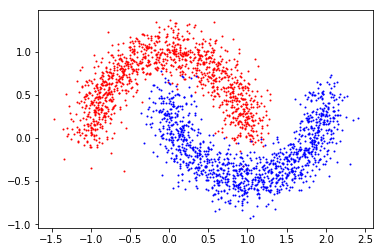

In [3]:
plt.scatter([X_train[i,0] for i in range(X_train.shape[0]) if y[i] == 0],
            [X_train[i,1] for i in range(X_train.shape[0]) if y[i] == 0], s=1, color='r')
plt.scatter([X_train[i,0] for i in range(X_train.shape[0]) if y[i] == 1], 
            [X_train[i,1] for i in range(X_train.shape[0]) if y[i] == 1], s=1, color='b')
plt.show()

In [4]:
def random_data(X, y, n):
    idx = np.random.randint(0, X.shape[0], n)
    return np.c_[np.ones((n,1), dtype=float),X[idx]], y[idx].reshape(-1,1).astype(float)

In [5]:
def logistic_regression(X_train, y_train, learning_rate=0.001, n_epochs = 1000, batch_size = 24):

    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs_LR"
    logdir = "{}/run-{}".format(root_logdir, now)

    print(logdir)

    tf.reset_default_graph()

    n_batches = int(np.ceil(X_train.shape[0] / batch_size))
    num_features = X.shape[1]

    X_batch = tf.placeholder(tf.float32, shape=(None, num_features+1), name="X")
    y_batch = tf.placeholder(tf.float32, shape=(None, 1), name='y')
    theta = tf.Variable(tf.random_uniform([num_features+1, 1], -1.0, 1.0), name='theta')
    y_pred = tf.nn.sigmoid(tf.matmul(X_batch, theta, name='predictions'))
    mse = tf.reduce_mean(tf.square(y_pred - y_batch), name='MSE')
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(mse)
    mse_summary = tf.summary.scalar('MSE', mse)
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            if epoch % 100 == 0:
                print('Epoch:', epoch, "MSE:", mse.eval(feed_dict={X_batch: np.c_[np.ones((X_train.shape[0],1)),X_train], 
                                                                   y_batch: y_train.reshape(-1,1)}))
                save_path = saver.save(sess, "tmp2/my_model")
            for batch_index in range(n_batches):
                X_random, y_random = random_data(X, y, batch_size)
                sess.run(training_op, feed_dict={X_batch: X_random, y_batch: y_random})
            if epoch % 5:
                summary_str = mse_summary.eval(feed_dict={X_batch: np.c_[np.ones((X_train.shape[0],1)),X_train], 
                                                                   y_batch: y_train.reshape(-1,1)})
                file_writer.add_summary(summary_str, epoch*n_batches + batch_index)
        theta = theta.eval()
        save_path = saver.save(sess, "tmp2/my_final_model")
        file_writer.close()
        
    return theta

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [7]:
def predict(data, theta):
    return (sigmoid(np.dot(np.c_[np.ones((data.shape[0],1)),data],theta)) > 0.5)

In [8]:
def plot_decision_boundary(data, y, theta):
    
    x_min, x_max = X[:,0].min() - 0.1, X[:,0].max() + 0.1
    y_min, y_max = X[:,1].min() - 0.1, X[:,1].max() + 0.1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/100), np.arange(y_min, y_max, (y_max-y_min)/100))
    mesh_data = np.c_[xx.reshape(-1,1),yy.reshape(-1,1)]
    mesh_pred = predict(mesh_data, theta).reshape(xx.shape)
    plt.scatter([data[i,0] for i in range(data.shape[0]) if y[i] == 0],
            [data[i,1] for i in range(data.shape[0]) if y[i] == 0], s=1, color='r')
    plt.scatter([data[i,0] for i in range(data.shape[0]) if y[i] == 1], 
            [data[i,1] for i in range(data.shape[0]) if y[i] == 1], s=1, color='b')
    plt.contour(xx, yy, mesh_pred, cmap=plt.cm.seismic)

In [9]:
theta = logistic_regression(X_train, y_train)

tf_logs_LR/run-20180419182953
Epoch: 0 MSE: 0.262197
Epoch: 100 MSE: 0.0843923
Epoch: 200 MSE: 0.0841158
Epoch: 300 MSE: 0.0841359
Epoch: 400 MSE: 0.0841109
Epoch: 500 MSE: 0.0841218
Epoch: 600 MSE: 0.0841311
Epoch: 700 MSE: 0.0841288
Epoch: 800 MSE: 0.0841269
Epoch: 900 MSE: 0.084127


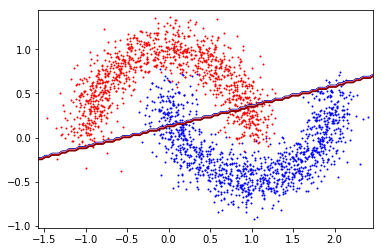

In [10]:
plot_decision_boundary(X_train, y_train, theta)

In [11]:
acc = np.sum(y_val.reshape(-1,1) == predict(X_val, theta)) / X_val.shape[0]
print('Validation accuracy:', acc)

Validation accuracy: 0.89
